In [ ]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
import numpy as np
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import cv2
from nuscenes.utils.geometry_utils import view_points, BoxVisibility
import matplotlib.patches as mpatches
from nuscenes.utils.data_classes import Box
import os 
from pyquaternion import Quaternion
from PIL import Image
import os
from collections import defaultdict
import motmetrics as mm
from shapely.geometry import Polygon
import pandas as pd
from filterpy.kalman import KalmanFilter
from filterpy.monte_carlo import systematic_resample
from numpy.random import uniform
from sklearn.metrics import mean_squared_error


nusc = NuScenes(version='v1.0-mini', dataroot='/Users/stefano_ruggiero/Desktop/3Dperc_p2/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.497 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [427]:
my_scene = nusc.scene[0]

In [428]:
my_sample = nusc.sample[10]

In [429]:
# nuscenes-lidarseg
nusc.get_sample_lidarseg_stats(my_sample['token'], sort_by='count')

===== Statistics for 023c4df2d451409881d8e6ea82f14704 =====
 14  vehicle.bicycle                          n=           2
 16  vehicle.bus.rigid                        n=           2
 21  vehicle.motorcycle                       n=           3
  4  human.pedestrian.construction_worker     n=           7
 11  movable_object.pushable_pullable         n=           8
  0  noise                                    n=          10
 12  movable_object.trafficcone               n=          41
 18  vehicle.construction                     n=          44
  2  human.pedestrian.adult                   n=          94
 17  vehicle.car                              n=         120
 23  vehicle.truck                            n=         226
 25  flat.other                               n=         374
 26  flat.sidewalk                            n=         605
  9  movable_object.barrier                   n=       1,064
 28  static.manmade                           n=       3,537
 27  flat.terrain        

In [430]:
def get_calibrated_points(nusc, pointsensor_token, camera_token):
    # Carica il point cloud
    pcl_path = nusc.get_sample_data_path(pointsensor_token)
    pc = LidarPointCloud.from_file(pcl_path)

    # Ottieni i record del sensore Lidar e della posa ego
    lidar_sd_record = nusc.get('sample_data', pointsensor_token)
    cs_record_lidar = nusc.get('calibrated_sensor', lidar_sd_record['calibrated_sensor_token'])
    pose_record_lidar = nusc.get('ego_pose', lidar_sd_record['ego_pose_token'])

    # Trasforma il point cloud nel frame del sensore Lidar al frame del veicolo ego
    pc.rotate(Quaternion(cs_record_lidar['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record_lidar['translation']))

    # Trasforma nel frame globale
    pc.rotate(Quaternion(pose_record_lidar['rotation']).rotation_matrix)
    pc.translate(np.array(pose_record_lidar['translation']))

    # Ottieni i record del sensore della camera e della posa ego
    cam_sd_record = nusc.get('sample_data', camera_token)
    cs_record_cam = nusc.get('calibrated_sensor', cam_sd_record['calibrated_sensor_token'])
    pose_record_cam = nusc.get('ego_pose', cam_sd_record['ego_pose_token'])

    # Trasforma dal frame globale al frame del veicolo ego al timestamp della camera
    pc.translate(-np.array(pose_record_cam['translation']))
    pc.rotate(Quaternion(pose_record_cam['rotation']).rotation_matrix.T)

    # Trasforma nel frame della camera
    pc.translate(-np.array(cs_record_cam['translation']))
    pc.rotate(Quaternion(cs_record_cam['rotation']).rotation_matrix.T)

    # Proietta i punti sul piano dell'immagine
    cam_intrinsic = np.array(cs_record_cam['camera_intrinsic'])
    points_3d_cam = pc.points[:3, :]  # Punti 3D nel frame della camera
    points_2d = view_points(points_3d_cam, cam_intrinsic, normalize=True)

    return points_2d, points_3d_cam


In [431]:
def get_projected_boxes(nusc, camera_token):
    cam_data = nusc.get('sample_data', camera_token)
    _, boxes, cam_intrinsic = nusc.get_sample_data(camera_token, box_vis_level=BoxVisibility.ALL)

    projected_boxes = []
    for box in boxes:
        corners_3d = box.corners()
        corners_2d = view_points(corners_3d, cam_intrinsic, normalize=True)[:2, :]
        projected_boxes.append(corners_2d)

    return projected_boxes

In [432]:
def get_projected_boxes_with_labels(nusc, camera_token):
    cam_data = nusc.get('sample_data', camera_token)
    _, boxes, cam_intrinsic = nusc.get_sample_data(camera_token, box_vis_level=BoxVisibility.ALL)
    
    projected_boxes = []
    box_labels = []
    for box in boxes:
        corners_3d = box.corners()
        corners_2d = view_points(corners_3d, cam_intrinsic, normalize=True)[:2, :]
        projected_boxes.append(corners_2d)
        box_labels.append(box.name)  # Recupera l'etichetta originale
    
    return projected_boxes, box_labels


In [433]:
def associate_points_to_boxes(points_2d, boxes_2d):
    # Creazione della matrice dei costi
    cost_matrix = []
    for point in points_2d.T:
        costs = []
        for box in boxes_2d:
            box_center = np.mean(box, axis=1)
            cost = np.linalg.norm(point[:2] - box_center[:2])  # distanza euclidea
            costs.append(cost)
        cost_matrix.append(costs)
    cost_matrix = np.array(cost_matrix)

    # Utilizzo di linear_sum_assignment per ottenere le associazioni -->algoritmo ungherese
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Filtraggio delle associazioni per rimuovere quelle con padding
    associations = [(row, col) for row, col in zip(row_indices, col_indices) 
                    if row < len(points_2d.T) and col < len(boxes_2d)]
    
    return associations


In [434]:
def get_box_labels_from_camera(nusc, camera_token):
    cam_data = nusc.get('sample_data', camera_token)
    my_sample = nusc.get('sample', cam_data['sample_token'])
    
    calibrated_sensor = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    cam_intrinsic = np.array(calibrated_sensor['camera_intrinsic'])
    
    box_labels = []
    boxes_2d = []
    valid_tokens = []  # Nuova lista per i token validi
    
    for ann_token in my_sample['anns']:
        box_3d = nusc.get('sample_annotation', ann_token)
        category_name = box_3d['category_name']
        
        box = nusc.get_box(ann_token)
        corners_3d = box.corners()
        corners_2d = view_points(corners_3d, cam_intrinsic, normalize=True)[:2, :]
        
        if np.all(corners_2d[0, :] > 0) and np.all(corners_2d[0, :] < cam_data['width']) and \
           np.all(corners_2d[1, :] > 0) and np.all(corners_2d[1, :] < cam_data['height']):
            boxes_2d.append(corners_2d)
            box_labels.append(category_name)
            valid_tokens.append(ann_token)  # Salva il token valido
    
    return box_labels, boxes_2d, valid_tokens


In [435]:

def visualize_associations(nusc, camera_token, points_2d, boxes_2d, associations):
    # Carica l'immagine della camera
    cam = nusc.get('sample_data', camera_token)
    img_path = os.path.join(nusc.dataroot, cam['filename'])
    img = Image.open(img_path)
    img_np = np.array(img)
    image_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    
    # Disegna i bounding box
    for i, box in enumerate(boxes_2d):
        plt.plot(box[0, [0, 1, 2, 3, 0]], box[1, [0, 1, 2, 3, 0]], 'b-', label="Box" if i == 0 else "")
    
    # Disegna i punti e le associazioni
    for i, (point_idx, box_idx) in enumerate(associations):
        point = points_2d[:, point_idx]
        box_center = np.mean(boxes_2d[box_idx], axis=1)
        
        # Disegna il punto lidar
        plt.plot(point[0], point[1], 'ro')
        
        # Disegna una linea di associazione
        plt.plot([point[0], box_center[0]], [point[1], box_center[1]], 'r--', linewidth=0.5)
    
    plt.xlabel("Coordinata X (pixel)")
    plt.ylabel("Coordinata Y (pixel)")
    plt.title("Associazione tra punti Lidar e bounding box nella vista della camera")
    plt.legend()
    plt.show()


In [436]:
def visualize_associations_with_labels(nusc, camera_token, points_2d, boxes_2d, box_labels, associations):
    # Carica l'immagine della camera
    cam = nusc.get('sample_data', camera_token)
    img_path = os.path.join(nusc.dataroot, cam['filename'])
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    img_height, img_width, _ = img_np.shape

    plt.figure(figsize=(12, 8))
    plt.imshow(img_np)
    plt.axis('off')

    # Creare una lista di colori distinti
    unique_labels = list(set(box_labels))
    num_labels = len(unique_labels)
    colors = plt.cm.get_cmap('hsv', num_labels)

    # Creare un dizionario che mappa le etichette ai colori
    label_color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

    # Disegna i bounding box e le categorie
    for i, box in enumerate(boxes_2d):
        label = box_labels[i]
        color = label_color_map[label]
        plt.plot(box[0, [0, 1, 2, 3, 0]], box[1, [0, 1, 2, 3, 0]], color=color, linewidth=2)
        
        # Aggiungi la categoria del box come testo al centro del box
        box_center = np.mean(box, axis=1)
        plt.text(box_center[0], box_center[1] - 10, label, color=color, fontsize=12, ha='center')

    # Disegna i punti associati ai box
    for i, (point_idx, box_idx) in enumerate(associations):
        point = points_2d[:, point_idx]
        if (0 <= point[0] <= img_width) and (0 <= point[1] <= img_height):
            label = box_labels[box_idx]
            color = label_color_map[label]
            # Disegna il punto lidar
            plt.plot(point[0], point[1], 'o', color=color, markersize=4)
            # Disegna una linea di associazione
            box_center = np.mean(boxes_2d[box_idx], axis=1)
            plt.plot([point[0], box_center[0]], [point[1], box_center[1]], '--', color=color, linewidth=0.5)

    # Aggiungi una legenda per le categorie
    legend_patches = [mpatches.Patch(color=label_color_map[label], label=label) for label in unique_labels]
    plt.legend(handles=legend_patches, loc='upper right')

    plt.title("Associazione tra punti Lidar e bounding box con etichette originali")
    plt.show()


In [437]:
def visualize_associations_with_legend(nusc, camera_token, points_2d, boxes_2d, box_labels, associations):
    # Carica l'immagine della camera
    cam = nusc.get('sample_data', camera_token)
    img_path = os.path.join(nusc.dataroot, cam['filename'])
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    img_height, img_width, _ = img_np.shape

    plt.figure(figsize=(12, 8))
    plt.imshow(img_np)
    plt.axis('off')

    # Creare una lista di colori distinti
    unique_labels = list(set(box_labels))
    num_labels = len(unique_labels)
    colors = plt.cm.get_cmap('tab20', num_labels)  # Usa una colormap con più colori

    # Creare un dizionario che mappa le etichette ai colori
    label_color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

    # Disegna i bounding box con colori corrispondenti alle etichette
    for i, box in enumerate(boxes_2d):
        label = box_labels[i]
        color = label_color_map[label]
        plt.plot(box[0, [0, 1, 2, 3, 0]],
                 box[1, [0, 1, 2, 3, 0]],
                 color=color,
                 linewidth=2)

        # Rimuovi le etichette dall'immagine
        # box_center = np.mean(box, axis=1)
        # plt.text(box_center[0], box_center[1] - 10, label, color=color, fontsize=10, ha='center',
        #          bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Disegna i punti associati ai box
    for i, (point_idx, box_idx) in enumerate(associations):
        point = points_2d[:, point_idx]
        if (0 <= point[0] <= img_width) and (0 <= point[1] <= img_height):
            label = box_labels[box_idx]
            color = label_color_map[label]
            # Disegna il punto Lidar
            plt.plot(point[0], point[1], 'o', color=color, markersize=3)
            # Disegna una linea di associazione
            box_center = np.mean(boxes_2d[box_idx], axis=1)
            plt.plot([point[0], box_center[0]], [point[1], box_center[1]],
                     '-', color=color, linewidth=0.5, alpha=0.5)

    # Aggiungi una legenda per le categorie
    legend_patches = [mpatches.Patch(color=label_color_map[label], label=label) for label in unique_labels]
    plt.legend(handles=legend_patches, loc='upper right')

    plt.title("Associazione tra punti Lidar e bounding box con legenda delle etichette")
    plt.show()


In [438]:
pointsensor_token = my_sample['data']['LIDAR_TOP'] 
camera_token = my_sample['data']['CAM_FRONT']

# Ottieni punti proiettati e bounding box con etichette
projected_points, points_3d_cam = get_calibrated_points(nusc, pointsensor_token, camera_token)
boxes_2d, box_labels = get_projected_boxes_with_labels(nusc, camera_token)

# Effettua la data association
associations = associate_points_to_boxes(projected_points, boxes_2d)


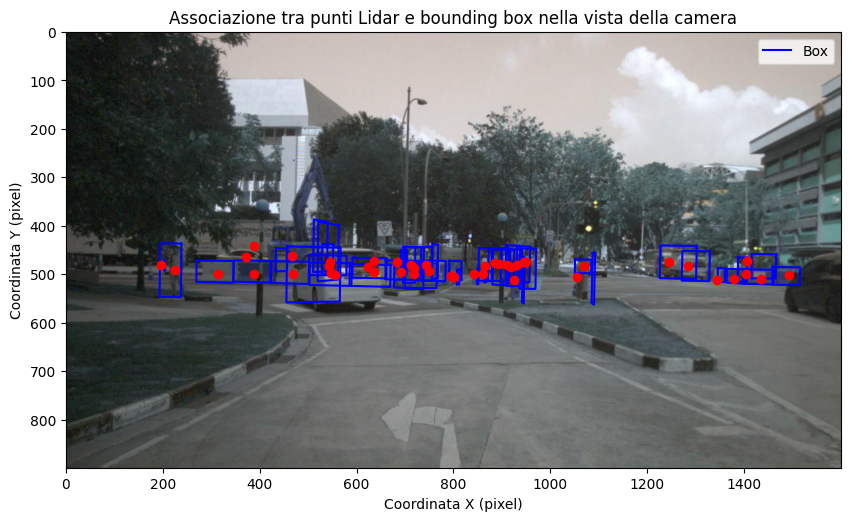

In [439]:
# Visualizza i risultati
visualize_associations(nusc, camera_token, projected_points, boxes_2d, associations)

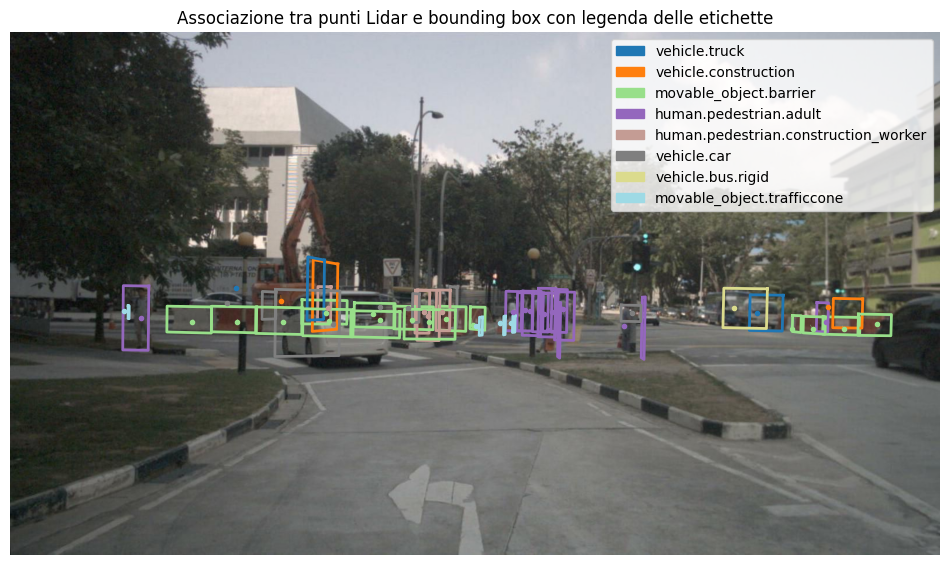

In [440]:
# Visualizza i risultati con la legenda
visualize_associations_with_legend(nusc, camera_token, projected_points, boxes_2d, box_labels, associations)

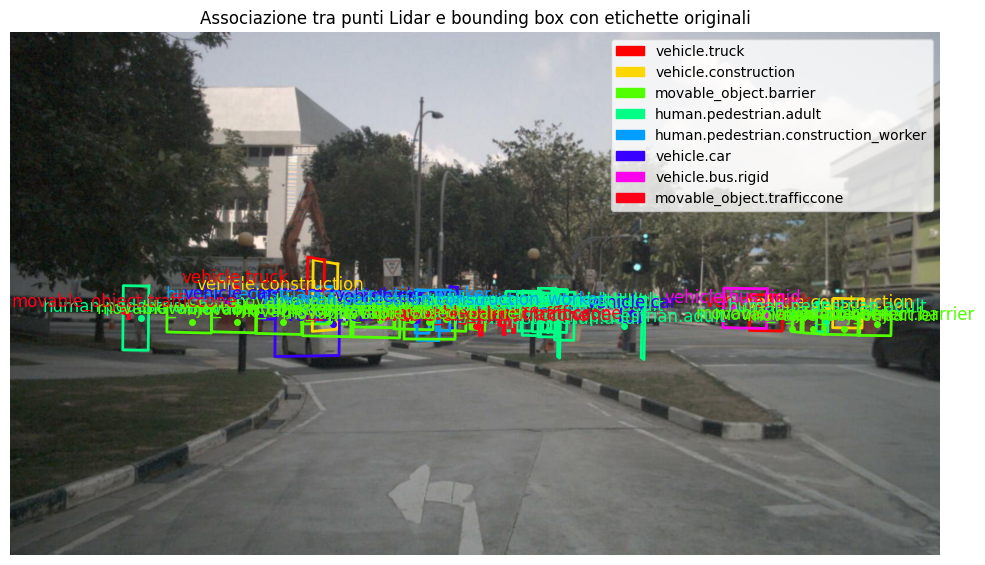

In [441]:
# Visualizza i risultati con le etichette 
visualize_associations_with_labels(nusc, camera_token, projected_points, boxes_2d, box_labels, associations)

SENSOR DATA FUSION FILTRO KALMAN

In [ ]:
# %%


class SensorFusionKF:
    def __init__(self, dt, process_var, measurement_var):
        # Initialize Kalman Filter
        self.kf = KalmanFilter(dim_x=4, dim_z=2)
        
        # Define the state transition matrix
        self.kf.F = np.array([[1, dt, 0, 0],
                              [0, 1,  0, 0],
                              [0, 0,  1, dt],
                              [0, 0,  0, 1]])
        
        # Define the measurement matrix
        self.kf.H = np.array([[1, 0, 0, 0],
                              [0, 0, 1, 0]])
        
        # Process and measurement noise
        self.kf.R *= measurement_var
        self.kf.Q = np.eye(4) * process_var
        
        # Initial state and covariance matrix
        self.kf.x = np.zeros(4)  # [x, vx, y, vy]
        self.kf.P *= 500.  # Initial uncertainty

    def predict(self):
        # Predict the next state
        self.kf.predict()
        return self.kf.x[:2]  # Return position [x, y]

    def update(self, measurement):
        # Update with a new measurement
        self.kf.update(measurement)

    def fuse_data(self, lidar_data, camera_data, associations):
        fused_positions = []
        for point_idx, box_idx in associations:
            lidar_point = lidar_data[:, point_idx][:2]  # Only [x, y] position
            camera_point = camera_data[box_idx].mean(axis=1)  # Average of bounding box corners as [x, y]
            
            # Predict and update the Kalman filter for each association
            self.predict()
            self.update(lidar_point)
            fused_positions.append(self.kf.x[:2])
        
        return fused_positions

    def print_fused_positions(self, fused_positions):
        print("Fused Positions (x, y):")
        for idx, pos in enumerate(fused_positions):
            print(f"Object {idx + 1}: x = {pos[0]:.2f}, y = {pos[1]:.2f}")
    
    def visualize_fused_positions_on_image(self, nusc, camera_token, fused_positions, boxes_2d, box_labels):
        # Carica l'immagine della camera
        cam_data = nusc.get('sample_data', camera_token)
        img_path = os.path.join(nusc.dataroot, cam_data['filename'])
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)
        img_height, img_width, _ = img_np.shape

        # Ottieni le intrinseche della camera
        cam_intrinsic = np.array(nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])['camera_intrinsic'])

        # Converte le posizioni fuse (coordinate 3D) in coordinate 2D proiettate sul piano dell'immagine
        points_3d_fused = np.array([[pos[0], pos[1], 0.001] for pos in fused_positions]).T  # Imposta z a un piccolo valore positivo per evitare divisione per zero
        points_2d_fused = view_points(points_3d_fused, cam_intrinsic, normalize=True)

        plt.figure(figsize=(12, 8))
        plt.imshow(img_np)
        plt.axis('off')

        # Colori distinti per ogni etichetta
        unique_labels = list(set(box_labels))
        num_labels = len(unique_labels)
        colors = plt.cm.get_cmap('tab20', num_labels)
        label_color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

        # Disegna i bounding box senza etichette testuali
        for i, box in enumerate(boxes_2d):
            label = box_labels[i]
            color = label_color_map[label]
            plt.plot(box[0, [0, 1, 2, 3, 0]], box[1, [0, 1, 2, 3, 0]], color=color, linewidth=2)

        # Disegna i punti fusi proiettati
        for i in range(points_2d_fused.shape[1]):
            x, y = points_2d_fused[0, i], points_2d_fused[1, i]
            if 0 <= x <= img_width and 0 <= y <= img_height:
                plt.plot(x, y, 'ro', markersize=5, label='Fused Position' if i == 0 else "")

        # Aggiungi una legenda per le categorie
        legend_patches = [mpatches.Patch(color=label_color_map[label], label=label) for label in unique_labels]
        plt.legend(handles=legend_patches, loc='upper right')

        plt.title("Proiezione delle Posizioni Fuse sull'Immagine della Scena")
        plt.show()


Fused Positions (x, y):
Object 1: x = -9.38, y = -0.93
Object 2: x = -12.05, y = -20.72
Object 3: x = -10.75, y = -4.03
Object 4: x = -5.21, y = 16.62
Object 5: x = -2.22, y = 20.13
Object 6: x = -0.50, y = 19.51
Object 7: x = 0.35, y = 17.49
Object 8: x = 17.37, y = 42.06
Object 9: x = 21.18, y = 41.48
Object 10: x = 23.20, y = 38.64
Object 11: x = 6.70, y = 13.24
Object 12: x = 2.23, y = 6.39
Object 13: x = 0.92, y = 4.19
Object 14: x = 0.62, y = 3.41
Object 15: x = 0.42, y = 2.84
Object 16: x = 0.38, y = 2.51
Object 17: x = 0.39, y = 2.26
Object 18: x = 5.32, y = 6.93
Object 19: x = 1.59, y = 2.59
Object 20: x = 0.60, y = 1.39
Object 21: x = 0.34, y = 1.00
Object 22: x = 0.20, y = 0.78
Object 23: x = 0.16, y = 0.66
Object 24: x = 0.13, y = 0.58
Object 25: x = 0.11, y = 0.50
Object 26: x = 0.10, y = 0.44
Object 27: x = 0.05, y = 0.35
Object 28: x = -0.00, y = 0.28
Object 29: x = -0.03, y = 0.22
Object 30: x = -0.04, y = 0.19
Object 31: x = -0.07, y = 0.15
Object 32: x = -0.08, y = 0.

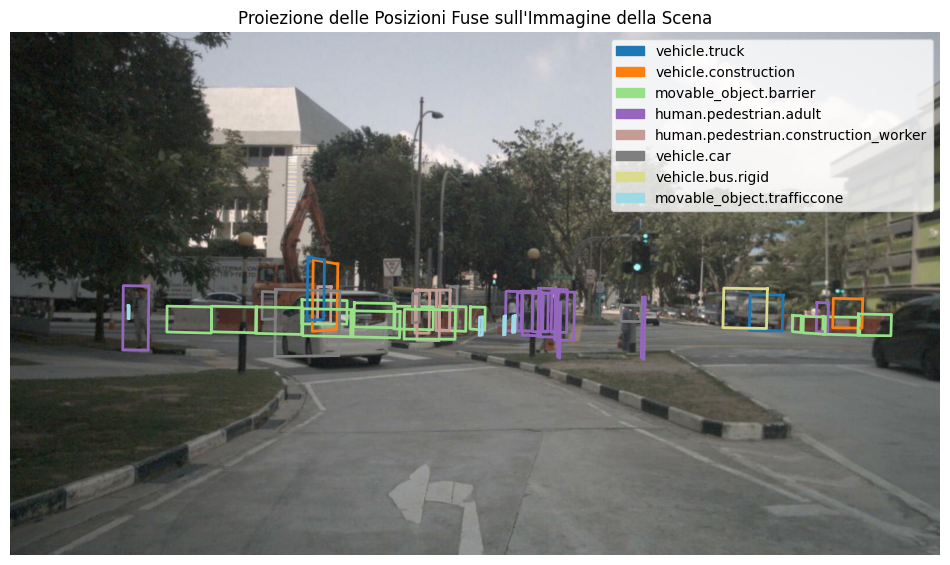

In [443]:
# Initialize SensorFusionKF with suitable parameters
fusion_kf = SensorFusionKF(dt=0.1, process_var=1.0, measurement_var=0.5)

# Fused positions
fused_positions = fusion_kf.fuse_data(points_3d_cam, boxes_2d, associations)

fusion_kf.print_fused_positions(fused_positions)

# Plot dei risultati
fusion_kf.visualize_fused_positions_on_image(nusc, camera_token, fused_positions, boxes_2d, box_labels)


PREDICTIONS CON PARTICLES FILTER

In [ ]:


class ParticleFilter:
    def __init__(self, num_particles, initial_position, process_var, measurement_var):
        # Numero di particelle
        self.num_particles = num_particles
        
        # Inizializzazione delle particelle e dei pesi
        self.particles = np.empty((self.num_particles, 2))  # [x, y] per ogni particella
        self.particles[:, 0] = initial_position[0] + uniform(-1, 1, size=self.num_particles)
        self.particles[:, 1] = initial_position[1] + uniform(-1, 1, size=self.num_particles)
        self.weights = np.ones(self.num_particles) / self.num_particles

        # Varianza del processo e della misura
        self.process_var = process_var
        self.measurement_var = measurement_var

    def predict(self, velocity):
        """ Aggiorna le particelle in base alla velocità stimata """
        # Aggiornamento delle particelle con un movimento casuale
        self.particles[:, 0] += velocity[0] + np.random.randn(self.num_particles) * self.process_var
        self.particles[:, 1] += velocity[1] + np.random.randn(self.num_particles) * self.process_var

    def update(self, measurement):
        """ Aggiorna i pesi delle particelle in base alla misura corrente """
        # Calcola la distanza tra le particelle e la misura
        distances = np.linalg.norm(self.particles - measurement, axis=1)
        # Aggiorna i pesi in base alla probabilità della misura
        self.weights *= np.exp(- (distances ** 2) / (2 * self.measurement_var))
        self.weights += 1.e-300  # per evitare pesi zero
        self.weights /= sum(self.weights)  # normalizza i pesi

    def resample(self):
        """ Esegue il resampling delle particelle """
        indices = systematic_resample(self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        """ Stima la posizione corrente come media ponderata delle particelle """
        return np.average(self.particles, weights=self.weights, axis=0)

    def run_filter(self, fused_data, velocities):
        """ Esegue il filtro sulle posizioni fuse """
        predictions = []
        for i, (measurement, velocity) in enumerate(zip(fused_data, velocities)):
            # Predizione delle particelle
            self.predict(velocity)
            
            # Aggiorna i pesi in base alla misura
            self.update(measurement)
            
            # Resampling se necessario
            if 1. / np.sum(self.weights ** 2) < self.num_particles / 2:
                self.resample()
                
            # Salva la posizione stimata corrente
            predictions.append(self.estimate())
        
        return predictions


In [445]:
def calculate_velocities(positions, dt=0.5): #0,5 secondi --> 2hz
    """
    Calcola le velocità tra i frame.
    
    Args:
        positions (list): Lista di posizioni [x, y] fuse tra i frame.
        dt (float): Intervallo di tempo tra i frame.

    Returns:
        velocities (list): Lista di velocità [vx, vy] tra i frame.
    """
    velocities = []
    for i in range(1, len(positions)):
        dx = positions[i][0] - positions[i - 1][0]
        dy = positions[i][1] - positions[i - 1][1]
        vx = dx / dt
        vy = dy / dt
        velocities.append([vx, vy])
    
    return velocities

In [446]:
# Inizializza il filtro a particelle
particle_filter = ParticleFilter(num_particles=100, initial_position=fused_positions[0], process_var=1.0, measurement_var=2.0)

velocities = calculate_velocities(fused_positions)

# Esegui il filtro a particelle sui dati fusi
predictions = particle_filter.run_filter(fused_positions, velocities)

# Stampa le predizioni
for i, pred in enumerate(predictions):
    print(f"Prediction {i + 1}: x = {pred[0]:.2f}, y = {pred[1]:.2f}")

Prediction 1: x = -13.88, y = -38.24
Prediction 2: x = -11.51, y = -6.72
Prediction 3: x = 0.29, y = 31.56
Prediction 4: x = 4.56, y = 36.72
Prediction 5: x = 6.33, y = 33.66
Prediction 6: x = 5.87, y = 28.08
Prediction 7: x = 40.02, y = 77.28
Prediction 8: x = 43.17, y = 75.46
Prediction 9: x = 46.36, y = 67.56
Prediction 10: x = 13.68, y = 20.21
Prediction 11: x = 4.78, y = 8.55
Prediction 12: x = 2.00, y = 4.84
Prediction 13: x = 1.06, y = 3.61
Prediction 14: x = 0.52, y = 3.08
Prediction 15: x = 0.80, y = 2.74
Prediction 16: x = 0.55, y = 2.20
Prediction 17: x = 8.04, y = 6.16
Prediction 18: x = 0.58, y = 0.66
Prediction 19: x = -0.43, y = -0.36
Prediction 20: x = -0.29, y = -0.30
Prediction 21: x = -0.09, y = 0.09
Prediction 22: x = 0.00, y = 0.19
Prediction 23: x = -0.05, y = 0.34
Prediction 24: x = -0.05, y = 0.40
Prediction 25: x = -0.00, y = 0.56
Prediction 26: x = 0.18, y = 0.56
Prediction 27: x = 0.05, y = 0.30
Prediction 28: x = -0.06, y = 0.25
Prediction 29: x = -0.09, y =

In [ ]:


def get_ground_truth_positions(nusc, scene):
    """
    Estrae le posizioni ground truth di ogni oggetto in ogni frame di una scena.

    Args:
        nusc (NuScenes): Istanza dell'oggetto NuScenes.
        scene (dict): Oggetto scena da analizzare.

    Returns:
        ground_truth_positions (list): Lista di liste contenenti le posizioni [x, y] 
                                       di ogni oggetto per ogni frame.
    """
    # Ottieni il primo sample token della scena
    sample_token = scene['first_sample_token']
    ground_truth_positions = []

    # Itera su tutti i frame della scena
    while sample_token:
        sample = nusc.get('sample', sample_token)
        sample_data_token = sample['data']['LIDAR_TOP']  # Assumi che il Lidar sia il sensore di riferimento
        boxes = nusc.get_boxes(sample_data_token)  # Ottieni le annotazioni per il frame corrente

        frame_positions = []
        for box in boxes:
            # Aggiungi la posizione [x, y] del centro dell'oggetto al frame corrente
            frame_positions.append([box.center[0], box.center[1]])

        ground_truth_positions.append(frame_positions)
        
        # Passa al prossimo frame
        sample_token = sample['next']
    
    return ground_truth_positions

ground_truth_positions = get_ground_truth_positions(nusc, my_scene)

In [448]:
for i, (pred, gt) in enumerate(zip(predictions, ground_truth_positions)):
    print(f"Frame {i+1} - Predizione: {pred}, Ground Truth: {gt}")

Frame 1 - Predizione: [-13.88380828 -38.24244925], Ground Truth: [[373.256, 1130.419], [378.888, 1153.348], [353.794, 1132.355], [376.13, 1158.507], [410.066, 1196.767], [372.664, 1129.247], [378.657, 1151.026], [409.132, 1201.516], [396.335, 1122.142], [394.842, 1158.711], [408.524, 1190.723], [417.399, 1193.55], [423.6, 1167.637], [356.068, 1144.504], [431.605, 1172.942], [394.05, 1156.846], [393.357, 1149.173], [371.763, 1129.172], [409.989, 1164.099], [392.077, 1104.169], [391.361, 1119.695], [387.52, 1143.568], [392.526, 1153.183], [396.227, 1164.778], [401.269, 1173.484], [399.012, 1167.878], [421.971, 1233.295], [438.348, 1171.033], [382.736, 1209.839], [386.807, 1141.706], [410.519, 1166.187], [379.731, 1153.227], [397.032, 1166.701], [377.041, 1147.53], [417.931, 1194.143], [390.073, 1149.573], [394.039, 1143.246], [391.734, 1151.279], [386.07, 1139.83], [401.282, 1193.478], [360.932, 1129.086], [400.519, 1171.691], [395.651, 1160.538], [398.565, 1110.043], [398.222, 1166.03],

In [ ]:


def calculate_rmse(predictions, ground_truth_positions):
    rmse_values = []
    for i, (pred, gt_positions) in enumerate(zip(predictions, ground_truth_positions)):
        if gt_positions:
            # Calcola RMSE per ogni oggetto nel frame corrente
            frame_rmse = []
            for gt in gt_positions:
                rmse = np.sqrt(mean_squared_error(pred, gt))
                frame_rmse.append(rmse)
            # Media degli RMSE per il frame corrente
            avg_frame_rmse = np.mean(frame_rmse)
            rmse_values.append(avg_frame_rmse)
    # Media degli RMSE tra i frame
    overall_rmse = np.mean(rmse_values)
    return overall_rmse


In [450]:
# Calcola l'RMSE per le tue predizioni rispetto al ground truth
overall_rmse = calculate_rmse(predictions, ground_truth_positions)
print(f"RMSE totale sulle predizioni: {overall_rmse:.2f}")

RMSE totale sulle predizioni: 836.84


In [451]:
def evaluate_dataset_rmse(nusc, scenes):
    total_rmse = []
    
    for i, scene in enumerate(scenes):
        # Ottieni le posizioni ground truth per la scena corrente
        ground_truth_positions = get_ground_truth_positions(nusc, scene)
        
        # Inizializza il filtro per la scena
        fused_positions = []
        predictions = []

        # Ciclo per ogni frame della scena
        sample_token = scene['first_sample_token']
        while sample_token:
            sample = nusc.get('sample', sample_token)
            pointsensor_token = sample['data']['LIDAR_TOP']
            camera_token = sample['data']['CAM_FRONT']
            
            # Ottieni punti e box proiettati per la fusione sensoriale
            projected_points, points_3d_cam = get_calibrated_points(nusc, pointsensor_token, camera_token)
            boxes_2d, box_labels = get_projected_boxes_with_labels(nusc, camera_token)
            associations = associate_points_to_boxes(projected_points, boxes_2d)

            # Fonde i dati per questo frame
            fusion_kf = SensorFusionKF(dt=0.1, process_var=1.0, measurement_var=0.5)
            fused_positions_frame = fusion_kf.fuse_data(points_3d_cam, boxes_2d, associations)
            fused_positions.extend(fused_positions_frame)
            
            # Calcola le velocità per il filtro a particelle
            velocities = calculate_velocities(fused_positions)
            
            # Filtro a particelle su posizioni fuse
            particle_filter = ParticleFilter(num_particles=100, initial_position=fused_positions[0], 
                                             process_var=1.0, measurement_var=2.0)
            predictions_frame = particle_filter.run_filter(fused_positions, velocities)
            predictions.extend(predictions_frame)
            
            # Passa al prossimo frame
            sample_token = sample['next']
        
        # Calcola l'RMSE per la scena corrente
        scene_rmse = calculate_rmse(predictions, ground_truth_positions)
        total_rmse.append(scene_rmse)
        
        # Stampa l'RMSE per la scena corrente
        print(f"RMSE per la scena {i + 1} ({scene['name']}): {scene_rmse:.2f}")

    # Media dell'RMSE per l'intero dataset
    dataset_rmse = np.mean(total_rmse)
    print(f"\nRMSE medio per l'intero dataset: {dataset_rmse:.2f}")


In [452]:
# Esegui la valutazione su tutte le scene
scenes = nusc.scene  # Ottieni tutte le scene dal dataset
dataset_rmse = evaluate_dataset_rmse(nusc, scenes)

RMSE per la scena 1 (scene-0061): 842.10
RMSE per la scena 2 (scene-0103): 1202.75
RMSE per la scena 3 (scene-0553): 1173.12
RMSE per la scena 4 (scene-0655): 1435.79
RMSE per la scena 5 (scene-0757): 592.14
RMSE per la scena 6 (scene-0796): 2284.67
RMSE per la scena 7 (scene-0916): 1357.44
RMSE per la scena 8 (scene-1077): 1413.59
RMSE per la scena 9 (scene-1094): 1334.38
RMSE per la scena 10 (scene-1100): 1070.78

RMSE medio per l'intero dataset: 1270.68
